In [1]:
import sys
import os
import logging

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from BDT import (
    read_data,
    read_features,
    prepare_test_data,
    prepare_test_data_matrix,
    prepare_data_matrix,
)
shap.initjs()

In [2]:
# load data and model
SPLIT_FRACTION = 0.5
data = read_data("./input/")
feature_names = read_features(data)
data_test = prepare_test_data(data, SPLIT_FRACTION)
test_data_matrix = prepare_test_data_matrix(data_test, feature_names)

X = data[feature_names]

booster = xgb.Booster()
booster.load_model("./output/booster.bin")

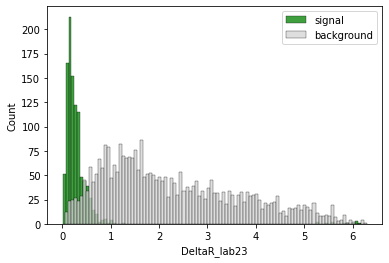

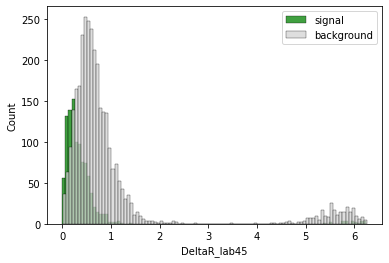

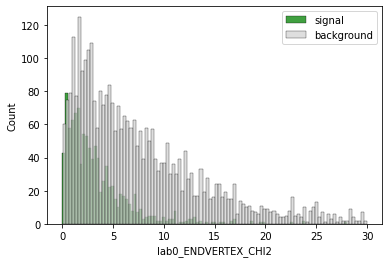

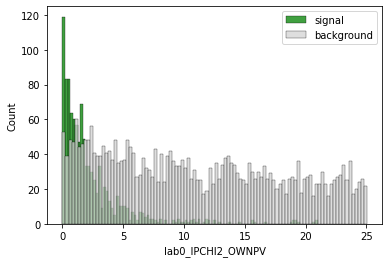

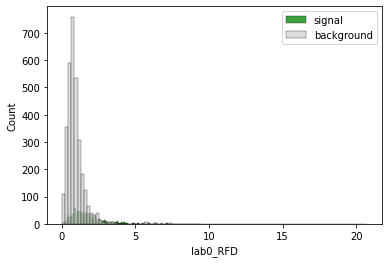

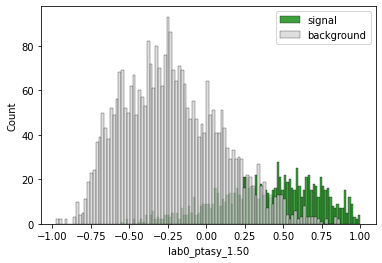

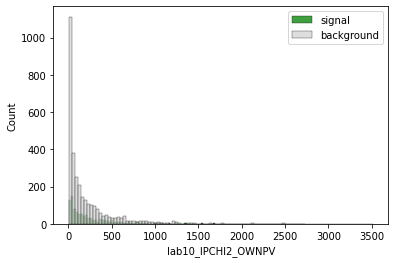

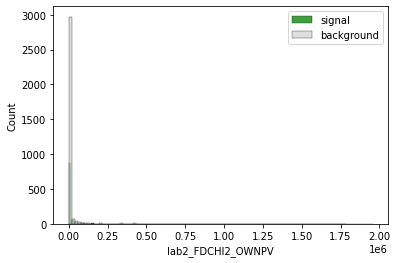

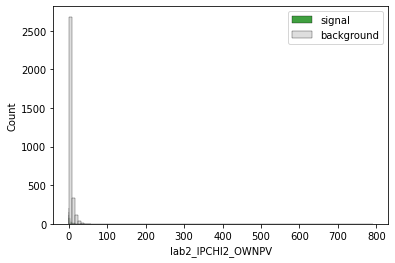

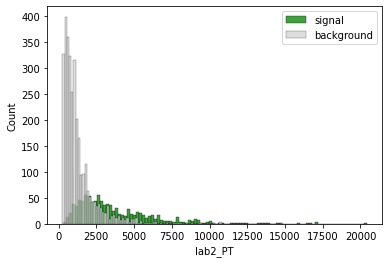

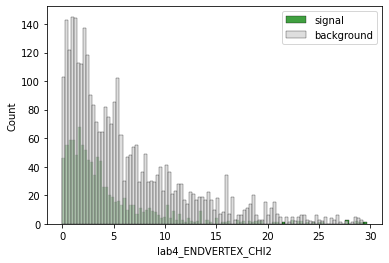

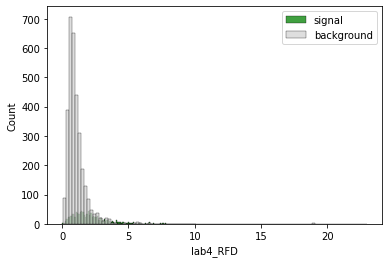

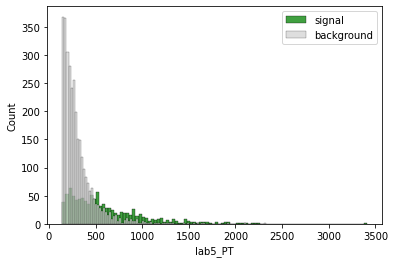

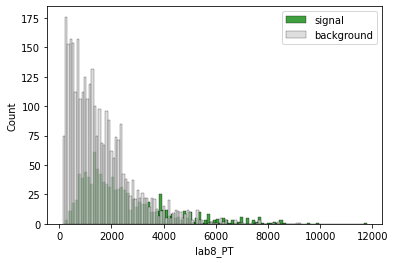

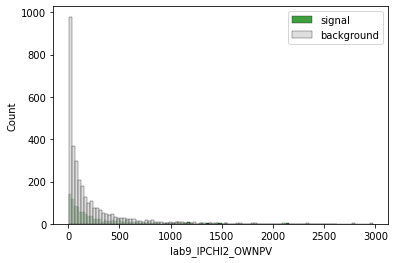

In [3]:
# Plot classification by feature
float_predictions = booster.predict(test_data_matrix).tolist()
predictions = list(map(round, float_predictions))
for feature_name in data_test[feature_names]:
    feature = pd.DataFrame(data_test[feature_name])
    feature.insert(1, "prediction", predictions, True)
    signal = feature[feature["prediction"] == 1]
    background = feature[feature["prediction"] == 0]
    
    plt.figure()
    sns.histplot(signal[feature_name], bins=100, color="green", label="signal")
    sns.histplot(background[feature_name], bins=100, color="lightgray", label="background")
    plt.legend()


In [4]:
# calculate shap values
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X)

In [5]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

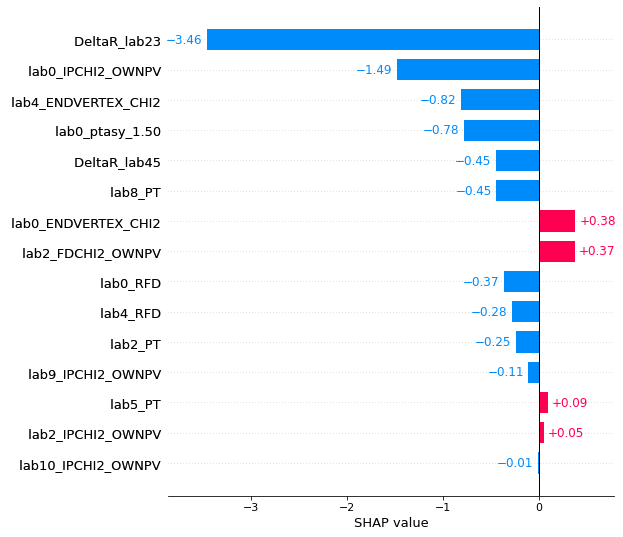

In [6]:
shap.plots.bar(explainer(X)[0], max_display=20)

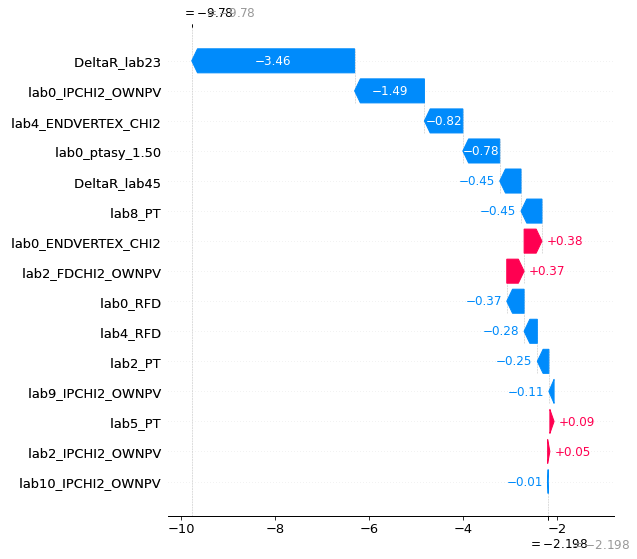

In [7]:
shap.waterfall_plot(explainer(X)[0], max_display=20)

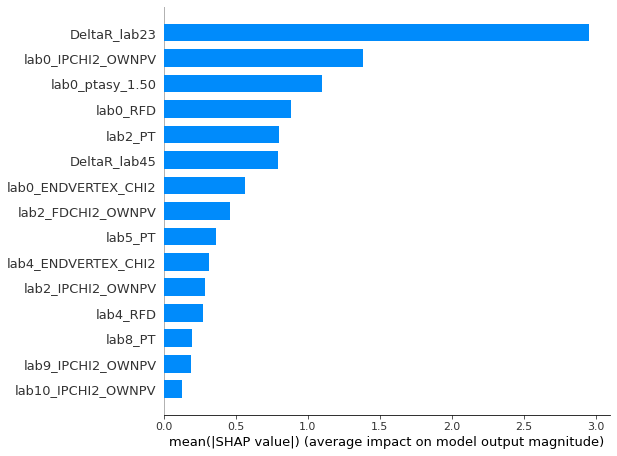

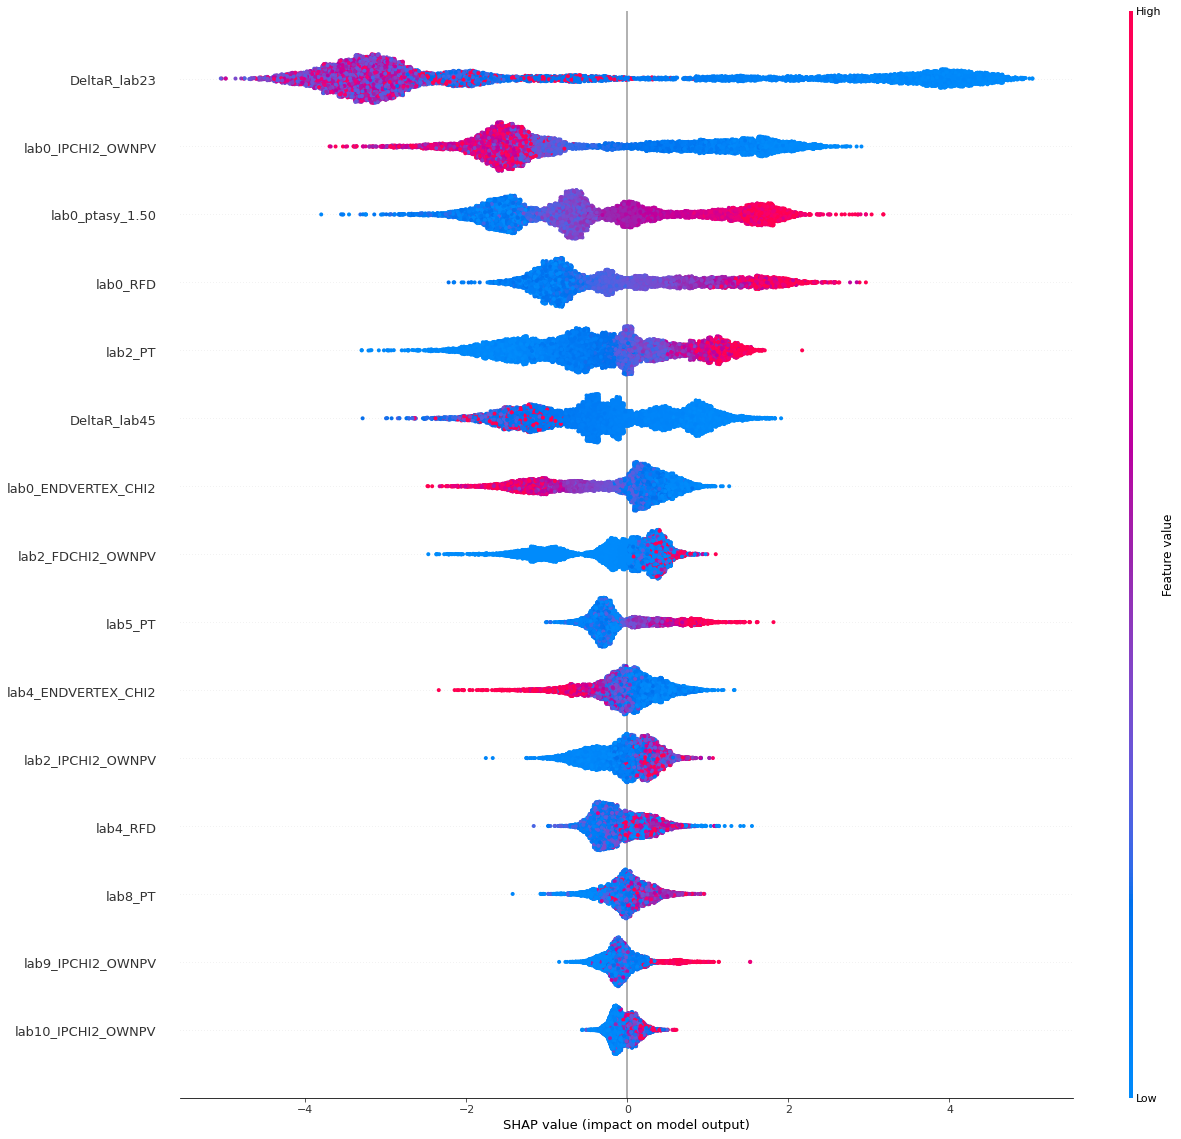

"\nWykres sumaryczny uwzględnia wszystkie cechy użyte w modelu. Prezentowane ponizej cechy są posortowane według\nwartości bezwzględnej ich wpływu na predykcje modelu. Cecha o największym wpływie na model to 'DeltaR_lab23', a ta\no najmniejszym wpływie na model to 'lab10_IPCHI2_OWNPV'. Ponadto patrząc na przykład na cechę 'DeltaR_lab23'\nmożna zauważyć, że niskie wartości tej cechy (niebieski kolor) mocno wpływają na zaklasyfikowanie próby jako sygnał.\n"

In [8]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X, plot_size=(20, 20))
"""
Wykres sumaryczny uwzględnia wszystkie cechy użyte w modelu. Prezentowane ponizej cechy są posortowane według
wartości bezwzględnej ich wpływu na predykcje modelu. Cecha o największym wpływie na model to 'DeltaR_lab23', a ta
o najmniejszym wpływie na model to 'lab10_IPCHI2_OWNPV'. Ponadto patrząc na przykład na cechę 'DeltaR_lab23'
można zauważyć, że niskie wartości tej cechy (niebieski kolor) mocno wpływają na zaklasyfikowanie próby jako sygnał.
"""

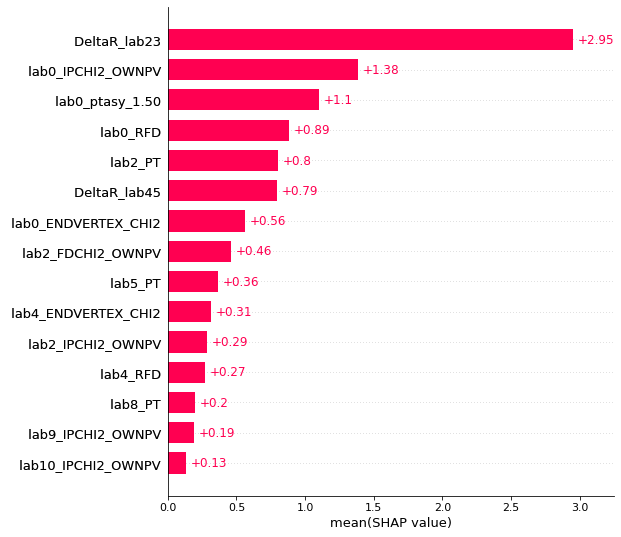

In [9]:
# global feature importance plot
shap.plots.bar(explainer(X), max_display=20)

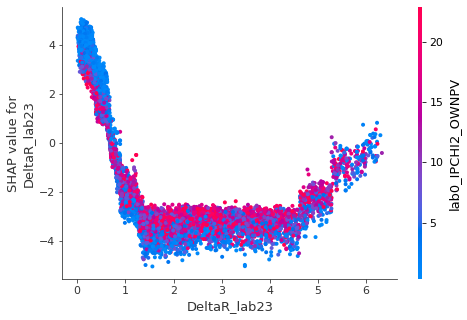

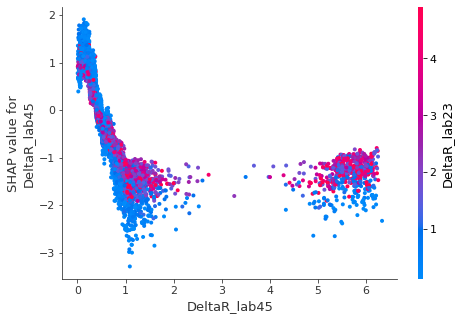

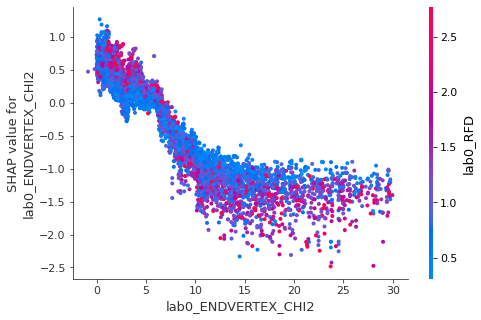

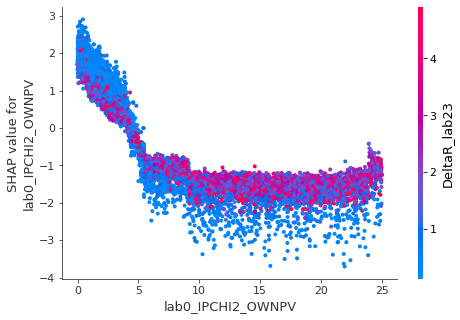

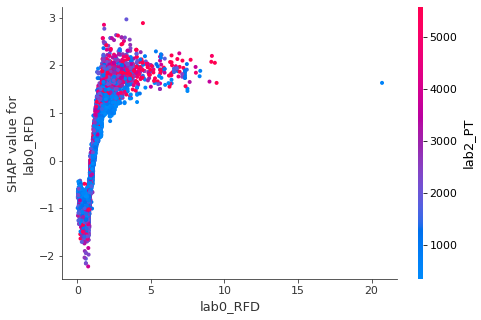

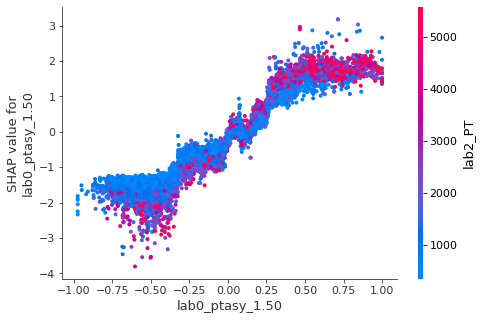

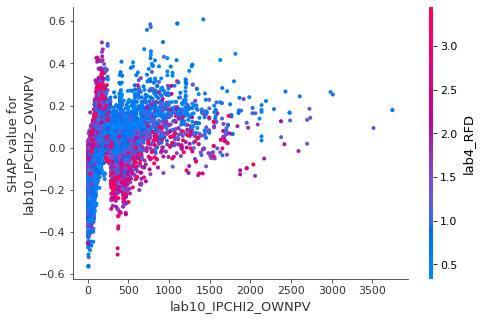

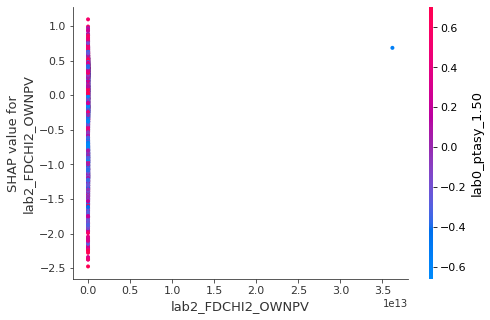

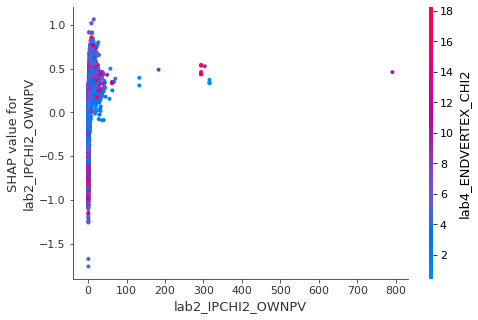

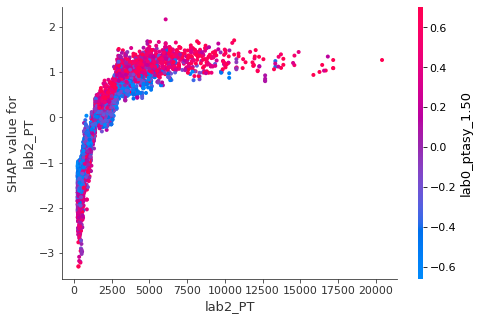

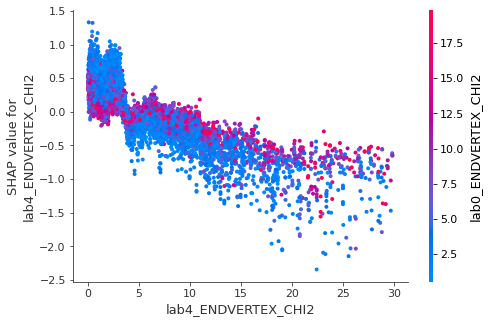

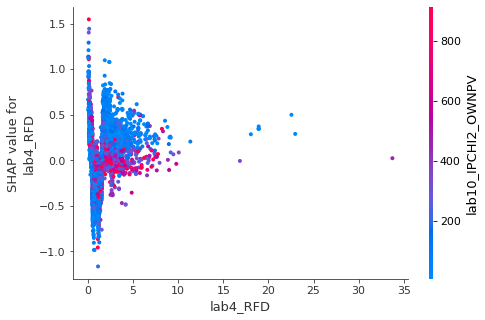

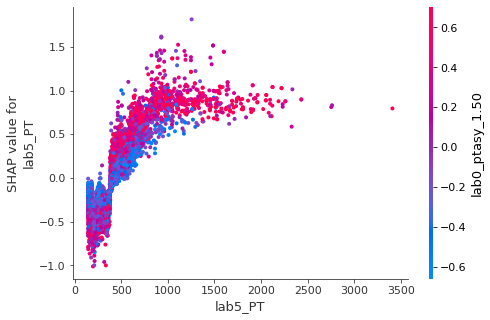

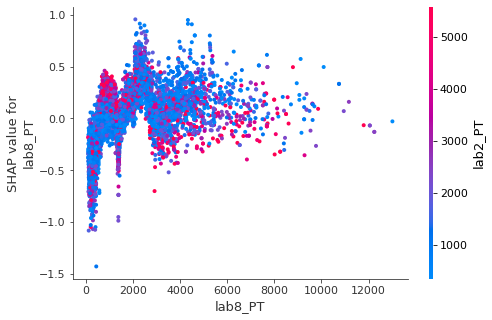

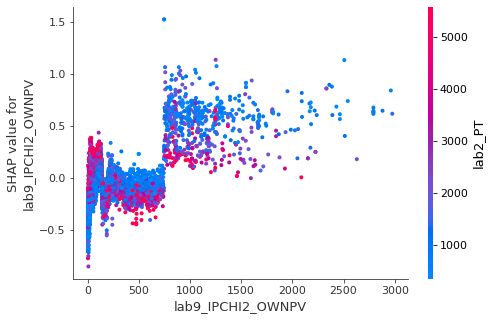

In [10]:
# dependence plots - 15*14=210 plots
# decide if there is any value in this
# the second feature (color) is chosen automatically by shap.common.approximate_interactions
for feature_name in feature_names:
    shap.dependence_plot(feature_name, shap_values, X)

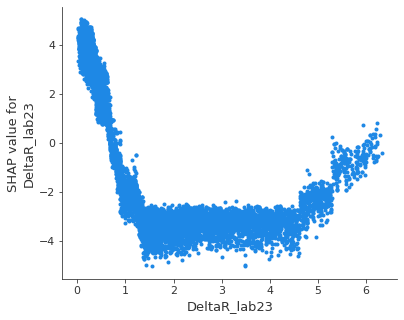

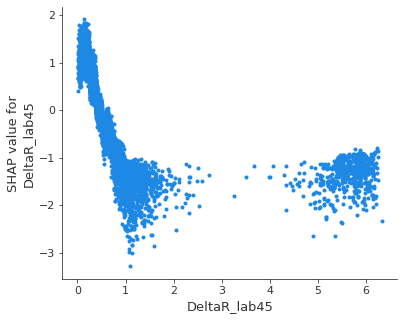

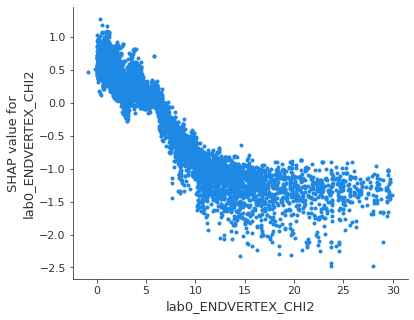

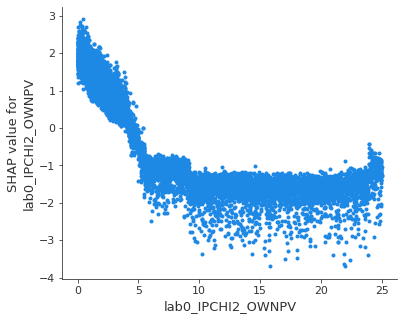

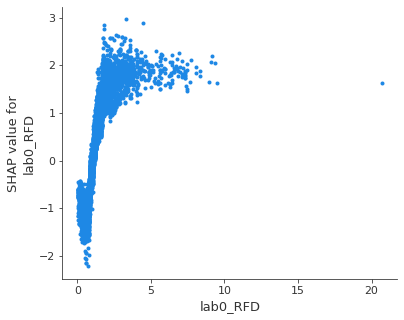

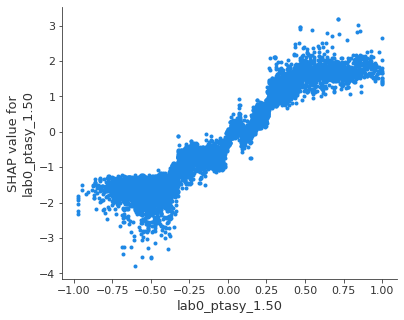

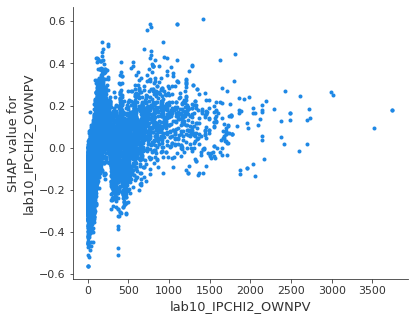

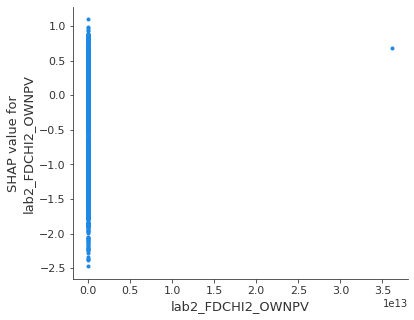

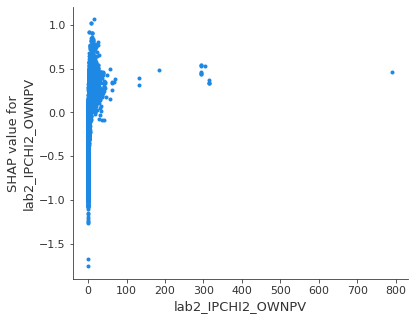

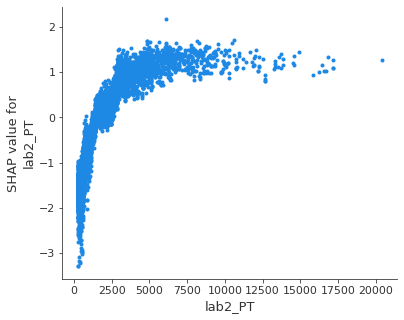

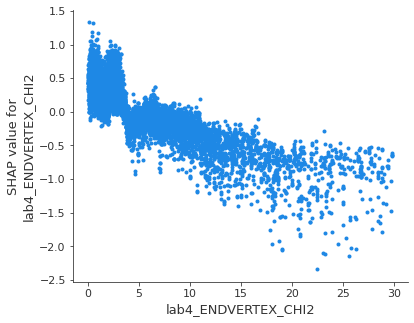

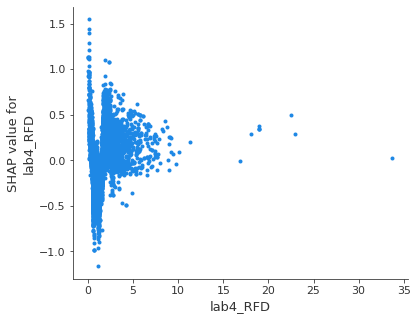

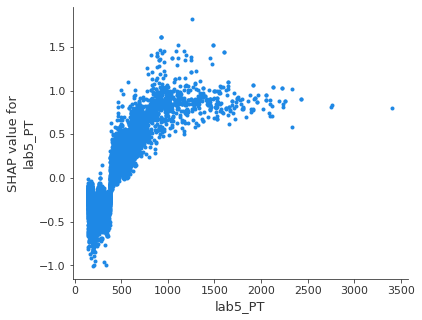

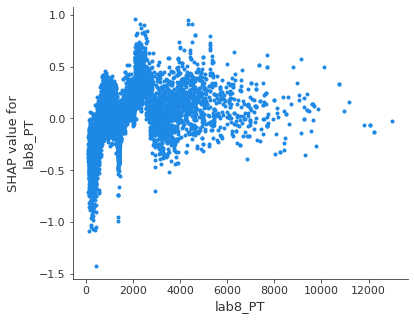

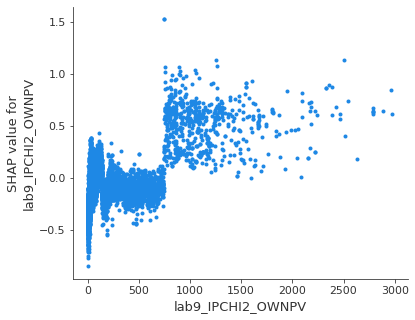

In [11]:
# Bez interakcji, tylko wpływ cechy na predykcje modelu
# Czy jest w tym jakaś wartościowa informacja?
for feature_name in feature_names:
    shap.dependence_plot(feature_name, shap_values, X, interaction_index=None)

In [12]:
# wizualizacja wpływu wszystkich cech na wiele prób (tutaj 100)
# raczej niepotrzebne
samples = 100
shap.force_plot(explainer.expected_value, shap_values[0:samples], X.iloc[0:samples])